# 오토인코더를 사용하여 이미지 잡음 제거

### STEP #1: 라이브러리 및 데이터셋 불러오기

In [27]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import random 
import os

In [28]:
# keras 라이브러리 불러오기
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

In [29]:
# 이미지 분류기를 위해 다양한 카테고리를 가진 cifar10 데이터셋 사용
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [30]:
X_train.shape

(50000, 32, 32, 3)

In [31]:
X_test.shape

(10000, 32, 32, 3)

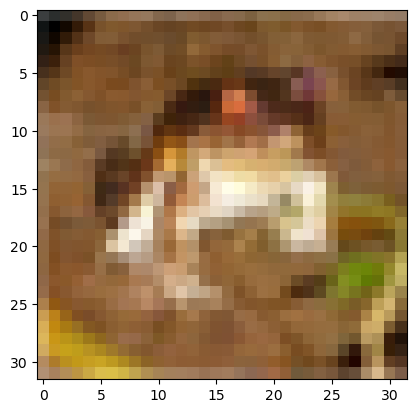

In [32]:
plt.imshow(X_train[0], cmap="gray")

### STEP #2: 데이터 이미지 출력

c:\ProgramData\anaconda3\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


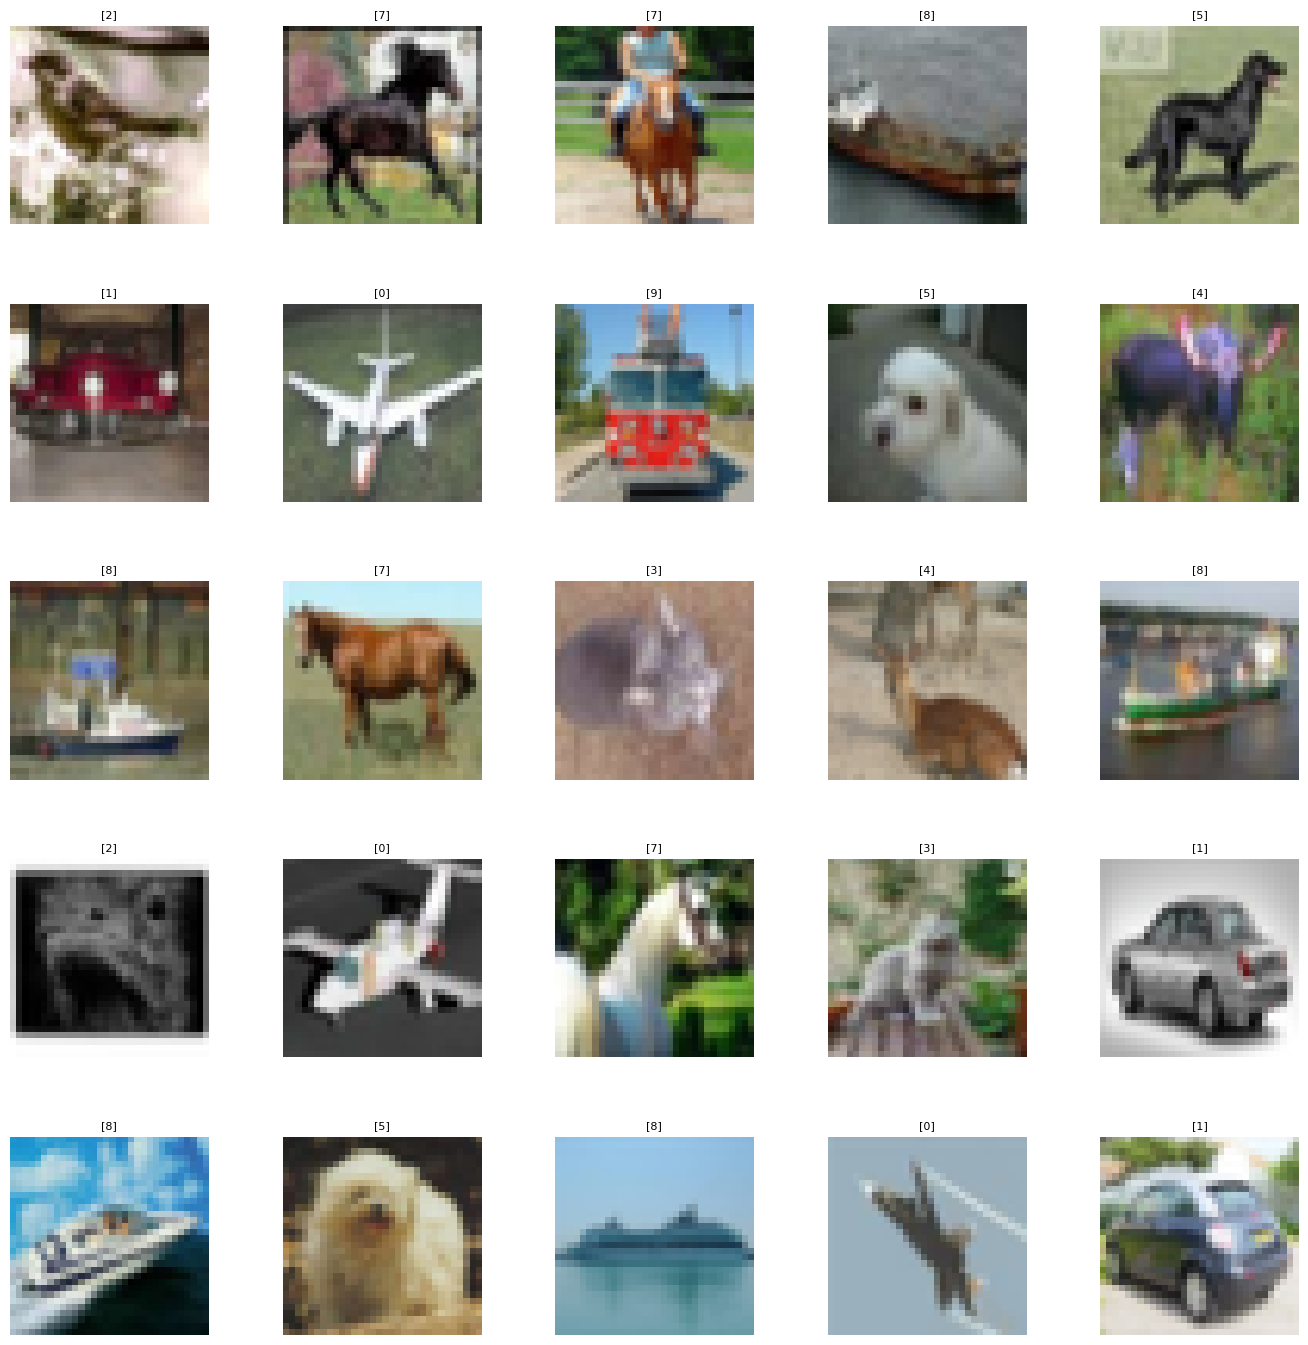

In [33]:
# 이미지 여러 개 출력
# 15 * 15 형식으로 출력
W_grid = 15
L_grid = 15

# subplots()함수 fig, axes 객체 리턴
fig, axes = plt.subplots(5, 5, figsize = (17,17))

# 15 * 15 행렬을 255크기의 배열로 바꿈
axes = axes.ravel() 

# 훈련용 데이터셋 크기 반환
n_training = len(X_train) 

# 0 ~ n_training 까지 중 랜덤한 인덱스의 데이터 이미지 출력
for i in np.arange(0, 5*5): 
    # 랜덤한 인덱스 지정
    index = np.random.randint(0, n_training)
    # 인덱스에 해당하는 데이터 이미지 출력
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

### STEP #3: 이미지 노이즈 추가

In [34]:
X_train = X_train / 255
X_test = X_test / 255

# 노이즈 강도 0.15
noise_factor = 0.15

# 노이즈 추가된 이미지 저장할 배열
noise_dataset = []

# 훈련용 데이터 노이즈 추가
for img in X_train:
  noisy_image = img + noise_factor * np.random.randn(*img.shape) # 이미지 픽셀에 노이즈 추가
  noisy_image = np.clip(noisy_image, 0., 1.) # 이미지 클리핑
  noise_dataset.append(noisy_image) # 노이즈 추가된 이미지 noise_dataset 배열에 추가

noise_dataset = np.array(noise_dataset)
noise_dataset.shape

(50000, 32, 32, 3)

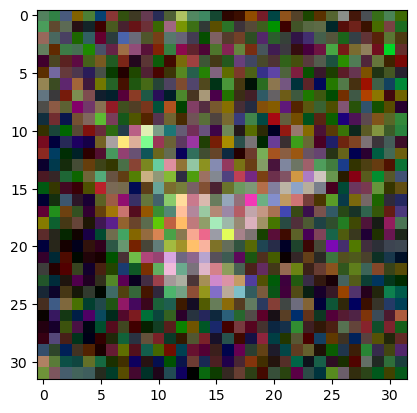

In [35]:
# 노이즈 추가된 이미지 하나 임의 출력
plt.imshow(noise_dataset[22], cmap="gray")

In [36]:
# 검증용 데이터 노이즈 추가
noise_test_set = []
for img in X_test:
  noisy_image = img + noise_factor * np.random.randn(*img.shape) # 이미지 픽셀에 노이즈 추가
  noisy_image = np.clip(noisy_image, 0., 1.) # 이미지 클리핑
  noise_test_set.append(noisy_image)  # 노이즈 추가된 이미지 noise_dataset 배열에 추가
  
noise_test_set = np.array(noise_test_set)
noise_test_set.shape

(10000, 32, 32, 3)

### STEP #4: 오토인코더 모델 설계 및 훈련(.fit())

In [37]:
# 입력 이미지의 형태 저장
input_shape = X_train.shape[1:]

# 오토인코더 모델 생성
autoencoder = tf.keras.models.Sequential([
    ### 인코더 부분
    # 이미지 특성 추출
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    # 2x2 최대 풀링을 사용하여 이미지 크기를 1/2배 (차원 축소 및 압축)
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    # 이미지 특성 추출
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    
    ### 디코더 부분
    # 이미지 특성 복원
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # 2x2 업샘플링을 사용하여 이미지 크기를 2배 (차원 복원 및 복원)
    tf.keras.layers.UpSampling2D((2, 2)),
    # 이미지 복원
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# 오토인코더 모델 컴파일
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))


In [38]:
# 오토인코더 모델 요약 출력
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 3)        

In [39]:
# 데이터 훈련
autoencoder.fit(noise_dataset, X_train, epochs=10, batch_size=128, validation_data=(noise_test_set, X_test))

Epoch 1/10
391/391 [==============================] - 104s 263ms/step - loss: 0.5696 - val_loss: 0.5608
Epoch 2/10
391/391 [==============================] - 106s 271ms/step - loss: 0.5590 - val_loss: 0.5590
Epoch 3/10
391/391 [==============================] - 97s 248ms/step - loss: 0.5579 - val_loss: 0.5583
Epoch 4/10
391/391 [==============================] - 110s 282ms/step - loss: 0.5574 - val_loss: 0.5581
Epoch 5/10
391/391 [==============================] - 106s 272ms/step - loss: 0.5571 - val_loss: 0.5578
Epoch 6/10
391/391 [==============================] - 116s 297ms/step - loss: 0.5569 - val_loss: 0.5575
Epoch 7/10
391/391 [==============================] - 106s 272ms/step - loss: 0.5566 - val_loss: 0.5572
Epoch 8/10
391/391 [==============================] - 106s 272ms/step - loss: 0.5564 - val_loss: 0.5571
Epoch 9/10
391/391 [==============================] - 107s 273ms/step - loss: 0.5563 - val_loss: 0.5570
Epoch 10/10
391/391 [==============================] - 103s 262ms

### STEP #5: 모델 성능 측정 및 노이즈 제거 예시 출력

In [40]:
# 모델 성능 측정 (예측 정확도 파라미터)
evaluation = autoencoder.evaluate(noise_test_set, X_test)
print('Test Accuracy : {:.3f}'.format(evaluation))

313/313 [==============================] - 7s 22ms/step - loss: 0.5568
Test Accuracy : 0.557


In [41]:
# 오토인코더 노이즈 제거 출력을 위한 예측 결과 저장
predicted = autoencoder.predict(noise_test_set[:10000])

313/313 [==============================] - 7s 22ms/step


In [42]:
print(predicted.shape)
print(X_train[:10000].shape)

(10000, 32, 32, 3)
(10000, 32, 32, 3)


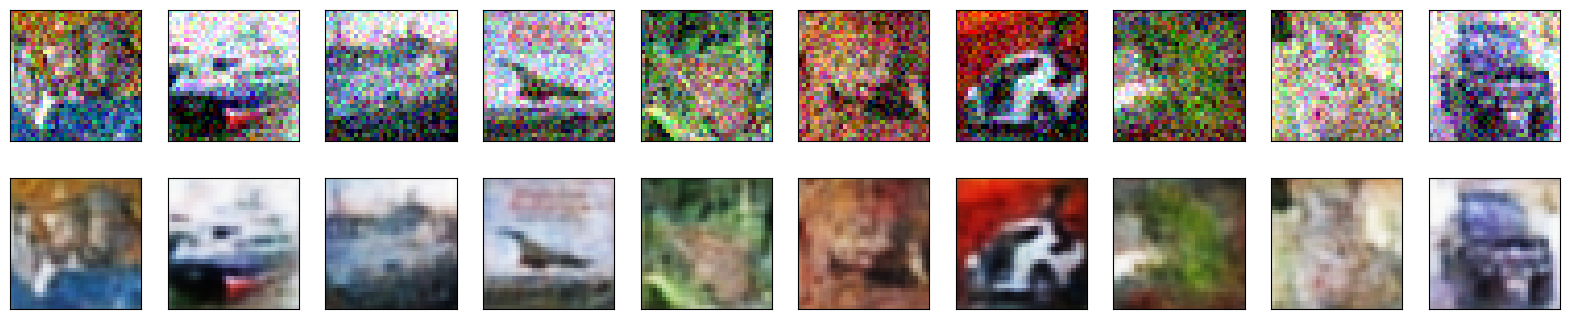

In [43]:
# 예측 결과 출력
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([noise_test_set[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((32, 32, 3)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Classification 수행

### STEP #1 : 오토인코더를 거친 잡음제거 이미지 데이터 훈련용/검증용 분류

In [44]:
from sklearn.model_selection import train_test_split

num_classes = 10

# 이미지 노이즈 제거를 위한 훈련 데이터 준비
X_train_autoencoder = predicted

# 훈련 데이터와 정답 레이블 준비
X_train_classifier = X_train_autoencoder
y_train_classifier = tf.keras.utils.to_categorical(y_test[:10000], num_classes)

# 훈련 및 검증 데이터로 분할
X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(X_train_classifier, y_train_classifier, test_size=0.2, random_state=42)

### STEP #2 : 이미지 분류기 모델 생성

In [45]:
classifier = tf.keras.models.Sequential([
    # Step 1 - Convolution
    tf.keras.layers.Conv2D(128, (3, 3), input_shape=(32, 32, 3), activation='relu'),  # 128개의 3x3 필터를 사용하여 합성곱을 수행하는 층
    # 입력 이미지의 크기: 32x32, 입력 채널 수: 3 (RGB 이미지)
    # 활성화 함수로 ReLU를 사용하여 비선형성을 도입
    
    # Adding another layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # 64개의 3x3 필터를 사용하여 합성곱을 수행하는 층
    # 이전 층에서 추출한 이미지 특성을 더욱 추상화하여 표현
    
    # Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # 2x2 최대 풀링을 사용하여 이미지 크기를 절반으로 줄임
    # 이미지의 중요한 특징을 보존하면서 공간 크기를 줄이고 계산 부담을 줄임
    
    # Adding another layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),  # 32개의 3x3 필터를 사용하여 합성곱을 수행하는 층
    # 더욱 추상화된 이미지 특성을 추출
    
    # Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # 2x2 최대 풀링을 사용하여 이미지 크기를 절반으로 줄임
    
    # Adding another layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),  # 32개의 3x3 필터를 사용하여 합성곱을 수행하는 층
    # 더욱 추상화된 이미지 특성을 추출
    
    # Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # 2x2 최대 풀링을 사용하여 이미지 크기를 절반으로 줄임
    
    # Flatten the layer
    tf.keras.layers.Flatten(),  # 다차원의 특성 맵을 1차원으로 평탄화
    
    # Fully connected layer
    tf.keras.layers.Dense(128, activation='relu'),  # 128개의 뉴런을 가지는 완전 연결층
    # 추출된 이미지 특성을 입력으로 받아 뉴런의 가중치와 편향을 사용하여 계산을 수행
    
    # Output layer
    tf.keras.layers.Dense(num_classes, activation='softmax')  # 클래스 개수만큼의 뉴런을 가지는 출력층
    # 소프트맥스 활성화 함수를 사용하여 각 클래스에 대한 확률 값을 출력
])

In [46]:
classifier.summary()
classifier.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 32)         

In [47]:
#fit()과정 batch=32, ephocs=10
classifier.fit(X_train_class, y_train_class, batch_size=32, epochs=10, validation_data=(X_val_class, y_val_class))

Epoch 1/10
250/250 [==============================] - 45s 174ms/step - loss: 2.0769 - accuracy: 0.2307 - val_loss: 1.7824 - val_accuracy: 0.3560
Epoch 2/10
250/250 [==============================] - 47s 187ms/step - loss: 1.6999 - accuracy: 0.3739 - val_loss: 1.6809 - val_accuracy: 0.3835
Epoch 3/10
250/250 [==============================] - 49s 197ms/step - loss: 1.5636 - accuracy: 0.4329 - val_loss: 1.5548 - val_accuracy: 0.4280
Epoch 4/10
250/250 [==============================] - 48s 194ms/step - loss: 1.4686 - accuracy: 0.4690 - val_loss: 1.5355 - val_accuracy: 0.4520
Epoch 5/10
250/250 [==============================] - 46s 185ms/step - loss: 1.3999 - accuracy: 0.4873 - val_loss: 1.5503 - val_accuracy: 0.4450
Epoch 6/10
250/250 [==============================] - 50s 202ms/step - loss: 1.3351 - accuracy: 0.5185 - val_loss: 1.4977 - val_accuracy: 0.4535
Epoch 7/10
250/250 [==============================] - 49s 196ms/step - loss: 1.2836 - accuracy: 0.5345 - val_loss: 1.4466 - val_ac

In [48]:
class_predicted = classifier.predict(X_val_class)

63/63 [==============================] - 3s 52ms/step


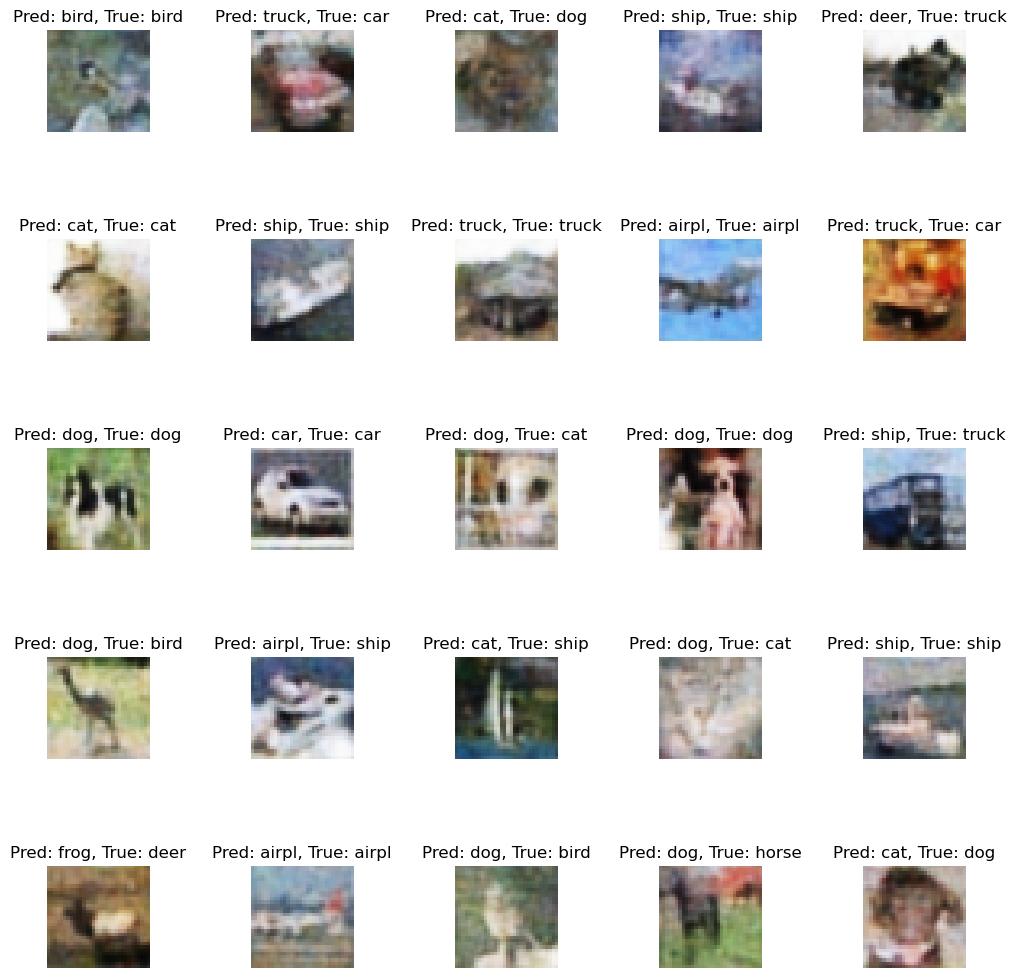

In [49]:
class_names = ['airpl', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 예측 결과 출력
predicted_labels = np.argmax(class_predicted, axis=1)
true_labels = np.argmax(y_val_class, axis=1)

# 예측 결과 시각화
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    # 이미지 출력
    ax.imshow(X_val_class[i])
    ax.axis('off')

    # 예측된 레이블과 실제 레이블 출력
    predicted_label = class_names[predicted_labels[i]]
    true_label = class_names[true_labels[i]]
    ax.set_title(f'Pred: {predicted_label}, True: {true_label}')

# 이미지 출력 간격 조절
plt.subplots_adjust(wspace=1.0, hspace=1.0)

plt.show()


In [50]:
# 모델 성능 측정 (예측 정확도 파라미터)
class_evaluation = classifier.evaluate(X_val_class, y_val_class)
print('Test Accuracy: {:.3f}'.format(class_evaluation[1]))

63/63 [==============================] - 3s 48ms/step - loss: 1.4581 - accuracy: 0.4850
Test Accuracy: 0.485
